In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import axis
import regex as re
import contractions
import num2words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB


import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /Users/grandhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/grandhi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/grandhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grandhi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grandhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data
data = pd.read_csv(
    "./data/nlp-getting-started/train.csv",)

# Encoding target variable
#data["target"] = np.where(data["target"] == "spam", 1, 0)

In [3]:
df = data.copy()
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Text(0.5, 1.0, 'General tweets and disaster tweets')

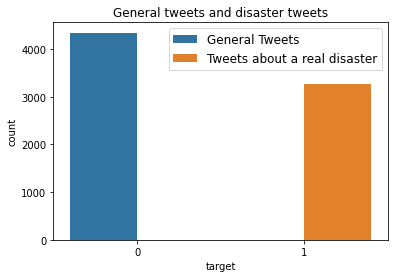

In [4]:
sns.countplot(data=df, x='target', hue='target' )
plt.legend(labels=["General Tweets","Tweets about a real disaster"],
           fontsize = 'large', title_fontsize = "10")
plt.title('General tweets and disaster tweets')

In [5]:
#df1 = df.groupby('keyword').size()
df1 = pd.crosstab(df.keyword,df.target).reset_index()
df1.rename(columns={0:'general',1:'disaster'},inplace=True)
df1.eval('total = general + disaster',inplace=True)
df1.sort_values(by='total',ascending=False,inplace=True)
df1 = df1.head(20)
df1

target,keyword,general,disaster,total
104,fatalities,19,26,45
63,deluge,36,6,42
8,armageddon,37,5,42
177,sinking,33,8,41
57,damage,22,19,41
119,harm,37,4,41
29,body%20bags,40,1,41
153,outbreak,1,39,40
95,evacuate,15,25,40
106,fear,35,5,40


In [6]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.general,
    name= 'General Tweets'
    
   
))
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.disaster,
    name = 'Disaster Tweets' ,
    marker_color='indianred'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                    title = 'Top 20 keywords used in the Tweets',
                    xaxis_title = 'keywords used in Tweets',
                    yaxis_title = 'counts',legend=dict(
                    yanchor="top",y=0.99,xanchor="left",x=0.80)
                    )
fig.show()


In [7]:
#filling null values with some number

df['keyword'].fillna('', inplace=True)
df['location'].fillna('',inplace=True)

# dropping the duplicates
df.drop_duplicates(subset ='text',keep=False, inplace=True)


# converting to strings

df['keyword'] = df['keyword'].astype('object')
df['location'] = df['location'].astype('object')
df['text'] = df['text'].astype('str')

# adding the columns keyword and text
df['text_final'] = df['keyword'] + ' ' + df['text']


### Expand Contractions

In [8]:
df['text_final_1'] = df['text_final'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])

In [9]:
#joining back the list of items into one string
df['text_final_1'] = [' '.join(map(str, l)) for l in df['text_final_1']]

In [10]:
df.sample(3)

,id,keyword,location,text,target,text_final,text_final_1
217,309,annihilated,"Greater Manchester, UK",@ACarewornHeart Have a good un fella sorry I w...,0,annihilated @ACarewornHeart Have a good un fel...,annihilated @ACarewornHeart Have a good un fel...
5701,8136,rescued,"Pennsylvania, USA",@Zak_Bagans pets r like part of the family. I ...,0,rescued @Zak_Bagans pets r like part of the fa...,rescued @Zak_Bagans pets r like part of the fa...
4370,6207,hijacker,"West Chester, PA",Remove the http://t.co/9Jxb3rx8mF and Linkury ...,0,hijacker Remove the http://t.co/9Jxb3rx8mF and...,hijacker Remove the http://t.co/9Jxb3rx8mF and...


### Noise Cleaning

In [11]:
# Noise Cleaning - spacing, special characters, lowercasing 

df['text_final_1'] = df['text_final_1'].str.lower()
df['text_final_1'] = df['text_final_1'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
df['text_final_2'] = df['text_final_1'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))



In [12]:
#nltk tokenization

df['text_final_1'] = df['text_final_1'].apply(word_tokenize)
df['text_final_2'] = df['text_final_2'].apply(word_tokenize)


In [13]:
# remove stop words

stop_words = set(stopwords.words('english'))

df['text_final_1'] = df['text_final_1'].apply(lambda x: [word for word in x if word not in stop_words])
df['text_final_1'] = [' '.join(map(str, l)) for l in df['text_final_1']]

df['text_final_2'] = df['text_final_2'].apply(lambda x: [word for word in x if word not in stop_words])
df['text_final_2'] = [' '.join(map(str, l)) for l in df['text_final_2']]

In [14]:
#df['text_final_3'] = df['text_final_1'].str.split().apply(lambda x: [num2words(word) for word in x if word.isdigit()])

In [15]:
df.sample(5)

,id,keyword,location,text,target,text_final,text_final_1,text_final_2
690,994,blazing,State of Georgia,@Blazing_Ben @PattyDs50 @gwfrazee @JoshuaAssar...,0,blazing @Blazing_Ben @PattyDs50 @gwfrazee @Jos...,blazing blazing_ben pattyds50 gwfrazee joshuaa...,blazing blazing ben pattyds gwfrazee joshuaass...
5455,7781,police,"Stratford, CT",Selection September Bridgeport men charged in ...,1,police Selection September Bridgeport men char...,police selection september bridgeport men char...,police selection september bridgeport men char...
6119,8735,sinking,,That horrible sinking feeling when youÛªve be...,1,sinking That horrible sinking feeling when you...,sinking horrible sinking feeling youûªve home ...,sinking horrible sinking feeling home phone re...
2927,4206,drowned,"United Kingdom,Fraserburgh",@Stephen_Georg Hey Stephen Remember that time ...,0,drowned @Stephen_Georg Hey Stephen Remember th...,drowned stephen_georg hey stephen remember tim...,drowned stephen georg hey stephen remember tim...
3632,5181,fatalities,"Washington, DC",#Saudi Arabia: #Abha: Fatalities reported foll...,1,fatalities #Saudi Arabia: #Abha: Fatalities re...,fatalities saudi arabia abha fatalities report...,fatalities saudi arabia abha fatalities report...


In [16]:
def remove_url(text):
    url = re.compile(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
    return url.sub(r'', text)

df['text_final_url'] = df['text_final_2'].apply(lambda x: remove_url(x))


In [17]:
# Split dataset between train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["text_final_url"], df["target"], random_state=0)

In [18]:
# Initialization
WNlemma = nltk.WordNetLemmatizer()

analyzer = TfidfVectorizer(min_df=0).build_analyzer()

def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in analyzer(doc))


lemm_vectorizer = TfidfVectorizer(min_df=1, analyzer=lemmatize_word)

# Transform X_train
X_train_lemm_vectorized = lemm_vectorizer.fit_transform(X_train)

In [19]:
# Train the model with lemmatized and vectorized dataset
model_lemm = LogisticRegression(max_iter=1500)
model_lemm.fit(X_train_lemm_vectorized, y_train)

# Predict the transformed test documents
predictions1 = model_lemm.predict(lemm_vectorizer.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions1)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, predictions1)))
print("precision = {:.3f}".format(precision_score(y_test, predictions1)))
print("recall = {:.3f}".format(recall_score(y_test, predictions1)))
# 78,79,80, 68

AUC = 0.776
accuracy = 0.791
precision = 0.794
recall = 0.680


In [20]:
from sklearn.svm import SVC

clf = SVC(kernel = 'rbf', gamma = 'scale', degree = 4, C = 100)
clf.fit(X_train_lemm_vectorized, y_train) 
y_pred_SVC = clf.predict(lemm_vectorizer.transform(X_test))

print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_SVC), 3))


Accuracy on test set: 0.793


In [21]:
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]


rs = RandomizedSearchCV(SVC(random_state=42), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=42)

# Fit randomized search object to data
rs.fit(X_train_lemm_vectorized, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.652 total time=   1.9s
[CV 3/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.677 total time=   1.9s
[CV 1/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.664 total time=   1.9s
[CV 4/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.683 total time=   1.9s
[CV 5/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.682 total time=   1.9s
[CV 3/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.688 total time=   2.2s
[CV 2/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.678 total time=   2.2s
[CV 1/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.691 total time=   2.3s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=sigmoid;, score=0.575 total time=   1.8s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=sigmoid;, score=0.576 total time=   1.8s
[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=si

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
                   param_distributions=[{'C': [0.01, 0.1, 1, 10, 100],
                                         'degree': [2, 3, 4],
                                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   'auto', 'scale'],
                                         'kernel': ['rbf', 'linear', 'poly',
                                                    'sigmoid']}],
                   random_state=42, scoring='accuracy', verbose=5)

In [22]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
svc_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = svc_best_rs.predict(lemm_vectorizer.transform(X_test))

print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_rs), 3))



Accuracy on test set: 0.793


In [23]:
import xgboost 

#xgboost on lemmatization

xgb = xgboost.XGBClassifier()

xgb.fit(X_train_lemm_vectorized,y_train)

y_pred_xgb = xgb.predict(lemm_vectorizer.transform(X_test))


print("AUC = {:.3f}".format(roc_auc_score(y_test, y_pred_xgb)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, y_pred_xgb)))
print("precision = {:.3f}".format(precision_score(y_test, y_pred_xgb)))
print("recall = {:.3f}".format(recall_score(y_test, y_pred_xgb)))

AUC = 0.748
accuracy = 0.774
precision = 0.826
recall = 0.587


In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train_lemm_vectorized, y_train)

y_pred_mnb = mnb.predict(lemm_vectorizer.transform(X_test))

print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_mnb), 3))


Accuracy on test set: 0.791


In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train_lemm_vectorized, y_train)

y_pred_knn = knn.predict(lemm_vectorizer.transform(X_test))

print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_knn), 3))



Accuracy on test set: 0.749


In [26]:
# SVC = Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100}
#XGB = Best parameters: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
#mnb = Best parameters: {'alpha': 1}
#knn = Best parameters: {'p': 2, 'n_neighbors': 9, 'leaf_size': 48}

In [27]:
from mlxtend.classifier import StackingCVClassifier

In [37]:

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

estimators = [  ('SVC1', SVC(kernel = 'rbf', gamma = 'scale', degree = 4, C = 100)),
                ('XGB' , XGBClassifier(C = 0.01, degree = 2, gamma = 1, kernel = 'rbf')),
                ('mmnb' , MultinomialNB()),
                ('knn' , KNeighborsClassifier(p = 1, n_neighbors= 9, leaf_size=48)) 
            ]

stacked_model = StackingClassifier(estimators =estimators, final_estimator = LogisticRegression())

cc = stacked_model.fit(X_train_lemm_vectorized,y_train)

[13:38:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "C", "degree", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:39:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "C", "degree", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:39:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

In [ ]:
y_predd = 

In [ ]:
def num_to_words(text):
	"""
	Return :- text which have all numbers or integers in the form of words
	Input :- string
	Output :- string
	"""
	# splitting text into words with space
	after_spliting = text.split()

	for index in range(len(after_spliting)):
		if after_spliting[index].isdigit():
			after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
	numbers_to_words = ' '.join(after_spliting)
	return numbers_to_words



#data['words'] = data['Value'].apply(num2words)	